In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('seaborn')

# Importing metrics to evaluate our model
from sklearn.metrics import precision_score, accuracy_score, recall_score, roc_curve, roc_auc_score, f1_score, confusion_matrix

# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

## Importing and cleaning our data

In [2]:
path = 'C:/Users/Roberto/Desktop/datasets/heart.csv'
data = pd.read_csv(path)
data.head().T

,0,1,2,3,4
Age,40,49,37,48,54
Sex,M,F,M,F,M
ChestPainType,ATA,NAP,ATA,ASY,NAP
RestingBP,140,160,130,138,150
Cholesterol,289,180,283,214,195
FastingBS,0,0,0,0,0
RestingECG,Normal,Normal,ST,Normal,Normal
MaxHR,172,156,98,108,122
ExerciseAngina,N,N,N,Y,N
Oldpeak,0.0,1.0,0.0,1.5,0.0


In [4]:
# Let's see the dimension of uot dataset
data.shape

(918, 12)

In [5]:
# Are there missing values?
data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
# Are there repeated values?
data.duplicated().sum()

0

Now let's check if we have outliers:

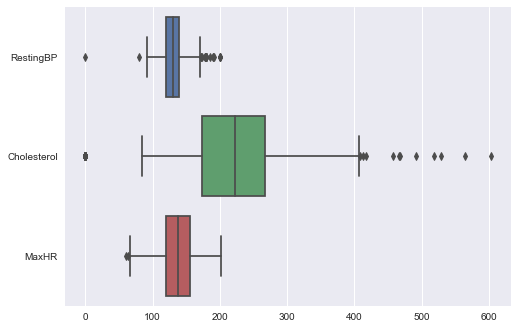

In [7]:
subdata = data[['RestingBP','Cholesterol','MaxHR']]
sb.boxplot(data=subdata, orient='h')
plt.show()

In [10]:
# Let's see the number of outliers we have by every variable:
def outliers(datos):
    
    # 1st and 2nd quantile computation
    Q1 = datos.quantile(0.25)
    Q3 = datos.quantile(0.75)
    
    # lower and upper bound computation
    IQR = Q3 - Q1 
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    
    # cleaning up the data
    CleanData = []
    
    for i in range(len(datos)):
        if datos[i] < lower_bound or datos[i] > upper_bound:
            datos[i] = np.random.uniform(lower_bound,upper_bound,1)
        CleanData.append(datos[i])
        
    return CleanData
    

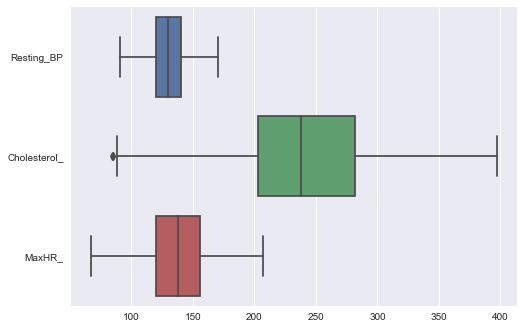

In [11]:
new_data = pd.DataFrame({'Resting_BP':outliers(data['RestingBP']),
                         'Cholesterol_':outliers(data['Cholesterol']),
                         'MaxHR_':outliers(data['MaxHR'])})

sb.boxplot(data=new_data, orient='h')
plt.show()


In [12]:
# Gathering this data into our original one
datos = pd.concat([data,new_data],1)
datos.drop(['RestingBP','Cholesterol','MaxHR'],axis=1, inplace=True)
datos.head()

,Age,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Resting_BP,Cholesterol_,MaxHR_
0,40,M,ATA,0,Normal,N,0.0,Up,0,140,289,172
1,49,F,NAP,0,Normal,N,1.0,Flat,1,160,180,156
2,37,M,ATA,0,ST,N,0.0,Up,0,130,283,98
3,48,F,ASY,0,Normal,Y,1.5,Flat,1,138,214,108
4,54,M,NAP,0,Normal,N,0.0,Up,0,150,195,122


We are almost done! 

Note there are some categorical variabels:
- ChestPainType
- RestingECG
- ExerciseAngina
- ST_Slope

We need to dummyfy them before proceding to use any ML Model over this dataset.

In [13]:
# Dummifying these variables:
dummy1 = pd.get_dummies(datos['ChestPainType']).iloc[:,:-1]
dummy2 = pd.get_dummies(datos['RestingECG']).iloc[:,:-1]
dummy3 = pd.get_dummies(datos['ExerciseAngina']).iloc[:,:-1]
dummy4 = pd.get_dummies(datos['ST_Slope']).iloc[:,:-1]
dummy5 = pd.get_dummies(datos['Sex']).iloc[:,:-1]

# Gathering them into the original dataframe:
df1 = pd.concat([datos,dummy1],axis=1)
df2 = pd.concat([df1,dummy2],axis=1)
df3 = pd.concat([df2,dummy3],axis=1)
df4 = pd.concat([df3,dummy4],axis=1)
df = pd.concat([df4,dummy5], axis=1)
df.drop(['ChestPainType','RestingECG','ExerciseAngina','ST_Slope','Sex'], axis=1, inplace=True)

In [14]:
df.head()

,Age,FastingBS,Oldpeak,HeartDisease,Resting_BP,Cholesterol_,MaxHR_,ASY,ATA,NAP,LVH,Normal,N,Down,Flat,F
0,40,0,0.0,0,140,289,172,0,1,0,0,1,1,0,0,0
1,49,0,1.0,1,160,180,156,0,0,1,0,1,1,0,1,1
2,37,0,0.0,0,130,283,98,0,1,0,0,0,1,0,0,0
3,48,0,1.5,1,138,214,108,1,0,0,0,1,0,0,1,1
4,54,0,0.0,0,150,195,122,0,0,1,0,1,1,0,0,0


As the dataset is clean, now we procede to perform the exploratory analysis.

## Exploratory Analysis

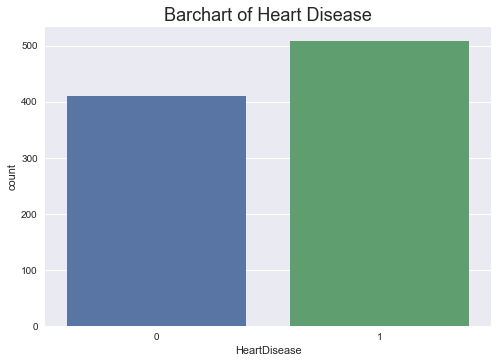

In [95]:
# Let's plot the proportion of people with and without Heart Disease
sb.countplot(data.HeartDisease)
plt.title('Barchart of Heart Disease', size=18)
plt.show()

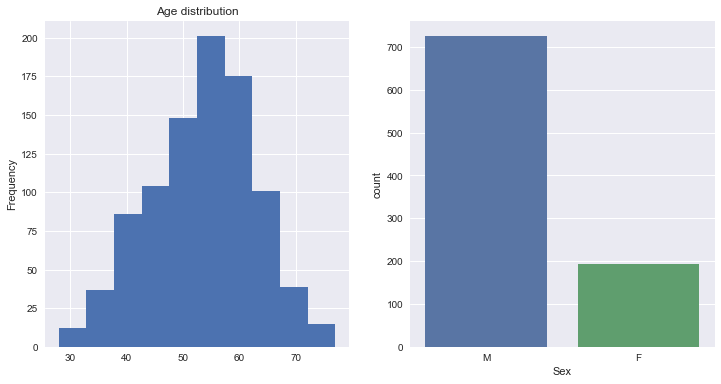

In [15]:
# Let's first explore the age and sex distributions
plt.figure(figsize=(18,4))

plt.subplot(1,2,1)
data.Age.plot(kind='hist', title='Age distribution', figsize=(12,6), xlabel='Range of ages')

plt.subplot(1,2,2)
sb.countplot('Sex', data=data)
#plt.title('Gender distribution')
plt.show()

**Observations**:
- The number of men in this study is higher than the number of women.
- The ages seems to follow a Normal distribution.

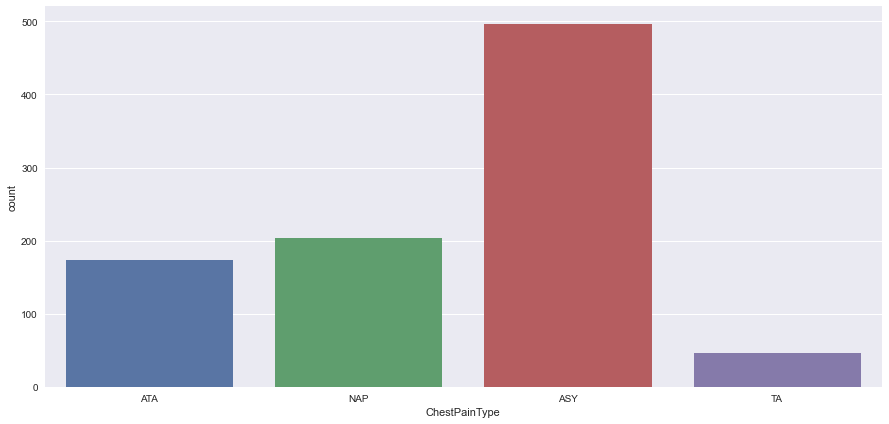

In [16]:
# Let's give a check to the types of chest pain
plt.figure(figsize=(15,7))

sb.countplot('ChestPainType', data=data)
#plt.title('Chest-Pain-Types')
plt.show()

**observations**:

- The most frequent chest pain is the **ASY**
- The lest common is **TA**

Let's see the type of chest pain by gender and ages:

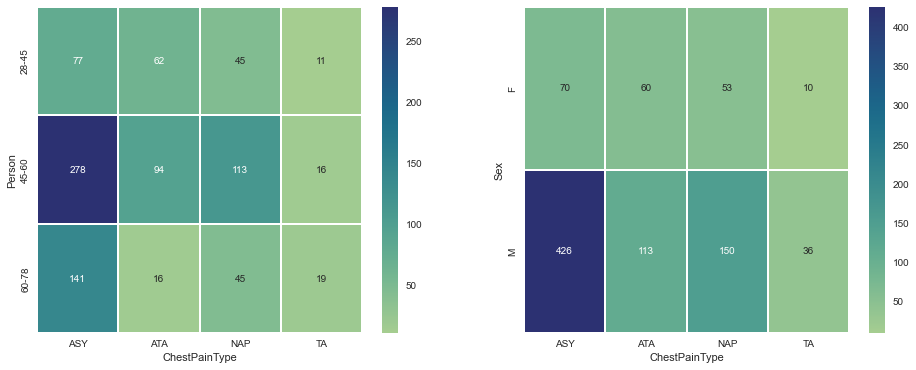

In [17]:
# DISTRIBUCIONES CONJUNTAS

# 1. Por edad y tipo de dolor:
Intervalos = [ min(data['Age']), 45, 60, max(data['Age']) ]
Etiquetas = [ '28-45', '45-60', '60-78' ]
data['Person'] = pd.cut( data['Age'], bins=Intervalos, labels=Etiquetas )
table1 = pd.crosstab(data['Person'],data['ChestPainType'])

# 2. Por genero y tipo de dolor
table2 = pd.crosstab(data['Sex'],data['ChestPainType'])

# Figura
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
sb.heatmap(table1, annot=True, fmt='d', cmap='crest', linewidth=2)

plt.subplot(1,2,2)
sb.heatmap(table2, annot=True, fmt='d', cmap='crest', linewidth=2)

plt.show()

### Observations
- The most common scenario is "men with ASY ChestPainType"
- Most people suffer ASY ChestPain within 45 years and 60 years

Let's now see whether there is a relation between the variables the three numeric variables we've prevouslly cleaned a while ago:

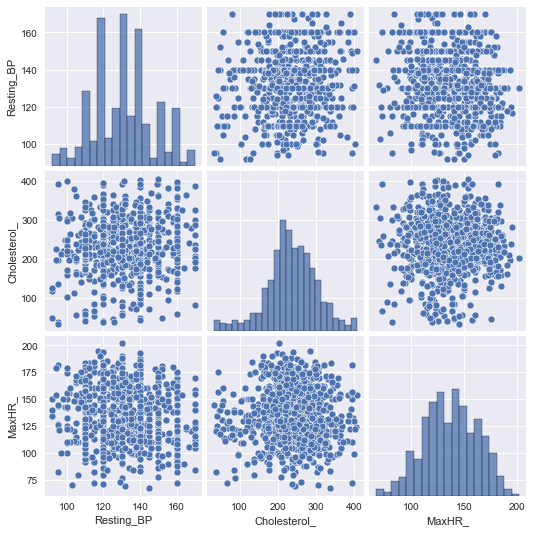

In [468]:
sb.pairplot(new_data)
plt.show()

We can appreciate there are no relation between any of these variables, which is actually good for us since ML models do not work very well with high correlated variables.

## Traning our Model

In [18]:
# MACHINE LEARNING LIBRARIES

# to create de train and test sets
from sklearn.model_selection import train_test_split

# to create de LR-model
from sklearn.linear_model import LogisticRegression

In [19]:
# setting down our variables:
Y = df['HeartDisease']
X = df.drop(['HeartDisease'],axis=1)

In [20]:
# dividimos nuestros datos en conjunto de prueba y entrenamiento:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75, random_state=42)

In [21]:
# Creamos el modelo
model = LogisticRegression()

model.fit(X_train,Y_train)

LogisticRegression()

As we want to minimize the **false negative rate** we'll choose a small threshold. Why? in this context we know that:
- False positives correspond to tell someone will have a heart desiase when they will alcually not.
- False negatives correspond to tell someone will not have a heart disease when they will actually have one.

For this reason is essential to reduce the number of false negatives as much as possible.

In [266]:
# Probabilidades
probabilidades = model.predict_proba(X_test)

# Calculo de los false positive rate, true positive rate y thresholds
fpr, tpr, thresholds = roc_curve(Y_test, probabilidades[:,1])

# Elejimos un threshold que nos minimize la suma: "falsos positivos + falsos negativos"
threshold = 0.32
"""
for t in thresholds:
    prediction = np.where(probabilidades[:,1]>=t, 1, 0)
    FP = confusion_matrix(Y_test, prediction)[0][1]
    FN = confusion_matrix(Y_test, prediction)[1][0]
    suma = FP + FN
    idx = np.argmin(suma)

opt_threshold = thresholds[idx]
print('El threshold optimo es',opt_threshold)
"""
prediction = np.where(probabilidades[:,1]>=threshold, 1, 0)

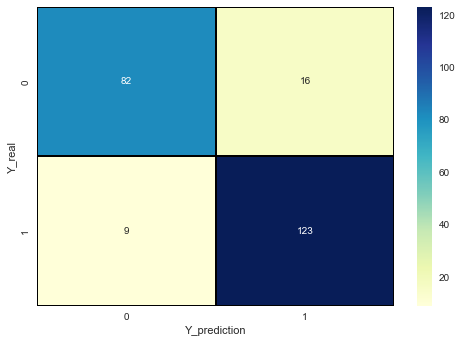

In [267]:
# Graficamos la matriz de confusion
results = pd.DataFrame({'Y_real':Y_test, 'Y_prediction':prediction})
tabla = pd.crosstab(results['Y_real'], results['Y_prediction'])
sb.heatmap(tabla, annot=True, fmt='d',linewidths=2, cmap="YlGnBu", linecolor='Black')
plt.show()

In [268]:
100-15/(15+82+123)*100

93.18181818181819

In [269]:
# Importing metrics to evaluate our model
from sklearn.metrics import precision_score, accuracy_score, recall_score, roc_curve, roc_auc_score, f1_score

In [270]:
# to implement cross-validation
from sklearn.model_selection import cross_val_score

# Calculamos la exactitud mediante la tecnica de validación cruzada
scores = cross_val_score(model, X, Y, scoring='accuracy', cv=5)
print('La exactitud mediante cross-validation es:',scores.mean())

La exactitud mediante cross-validation es: 0.8463352340223331


### Métricas de evaluación del modelo

- **Accuracy**: Nos da la proporción de aciertos de nuestro modelo 
$$
accuracy = \frac{VP+VN}{VP+VN+FP+FN}
$$

- **Precisión**: Proporción de valores que se han clasificado como positivos y que realmente lo son
$$
precisión = \frac{VP}{VP+FP}
$$

- **Recall**: Porporción de verdaderos positivos clasificados correctamente
$$
Recall = \frac{VP}{VP+FN}
$$

- **F1 score**: Es la media armonica de los dos anteriores. Un valor alto del F1 implica un alto valor en precisión y recall, es decir, al elevar el valor de F1 optimizamos el algoritmo. Esta métrica es muy usada cuando el dataset está desbalanceado. 

$$
F1 = 2\frac{Recall \cdot precisión}{Recall+ precisión}
$$

In [271]:
exactitud = accuracy_score(Y_test, prediction)
precision = precision_score(Y_test,prediction)
sensibilidad = recall_score(Y_test, prediction)
especificidad = recall_score(Y_test, prediction, pos_label=0)
f1 = f1_score(Y_test, prediction)

print('Exactitud:',round(exactitud,3))
print('Precisión:',round(precision,3))
print('Sensibilidad (Recall):',round(sensibilidad,3))
print('Especificidad:',round(especificidad,3))
print('F1:',round(f1,3))

Exactitud: 0.891
Precisión: 0.885
Sensibilidad (Recall): 0.932
Especificidad: 0.837
F1: 0.908


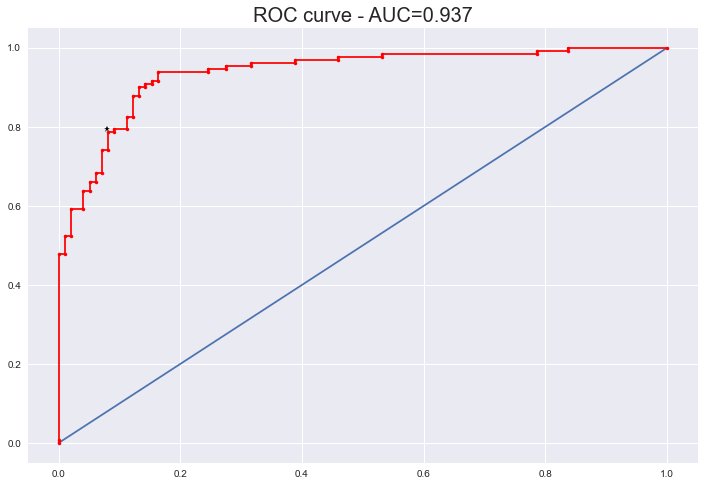

In [278]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

x = np.linspace(0,1,100)
y=x

plt.figure(figsize=(12,8))
auc = roc_auc_score(Y_test, probabilidades[:,1])
fpr, tpr, thresholds = roc_curve(Y_test, probabilidades[:,1])
plt.title('ROC curve - AUC='+str(round(auc,3)), size=20)
#plt.ylim('True positive rate')
#plt.xlim('False positive rate')
plt.plot(0.08,0.795, marker='*', c='Black')
plt.plot(x,y)
plt.plot(fpr, tpr, marker='.', c='r')
plt.show()